In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score

In [2]:
# Load the dataset (ensure the CSV file is in your working directory)
data = pd.read_csv("data/Country-data.csv")

In [3]:
# Display the first few rows
print("First 5 rows of the dataset:")
print(data.head())

First 5 rows of the dataset:
               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  


In [4]:
# Summary statistics for numeric columns
print("\nSummary Statistics:")
print(data.describe())


Summary Statistics:
       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.

In [5]:
# Check for missing values
print("\nMissing Values in each column:")
print(data.isnull().sum())


Missing Values in each column:
country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


In [6]:
# Identify numeric columns for further analysis
num_cols = data.select_dtypes(include=[np.number]).columns.tolist()
print("\nNumeric Columns:", num_cols)


Numeric Columns: ['child_mort', 'exports', 'health', 'imports', 'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']


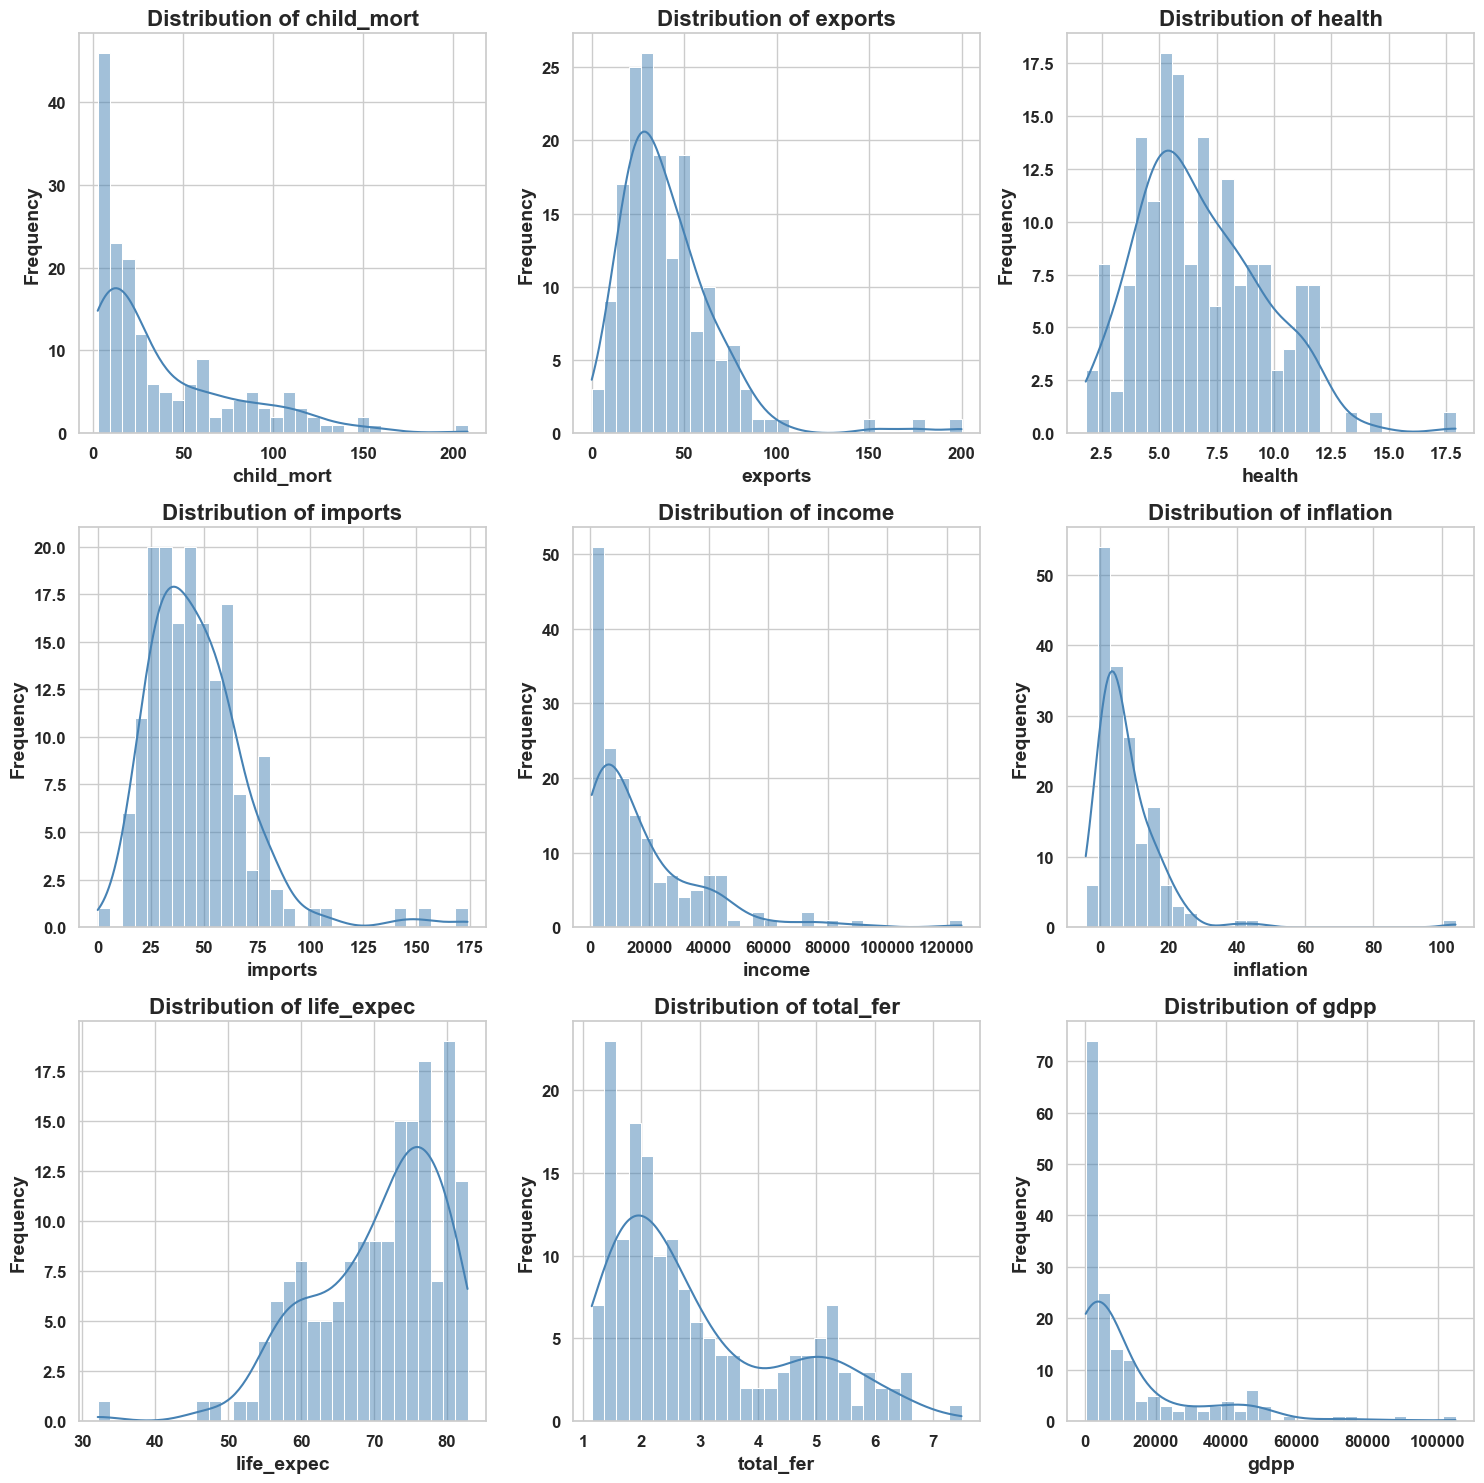

In [7]:
# Data Exploration

# Visualize distributions for numeric columns
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"

# Calculate how many rows/cols we need for subplots
num_plots = len(num_cols)
ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    sns.histplot(data[col], kde=True, bins=30, ax=axes[i], color="steelblue")
    axes[i].set_title(f"Distribution of {col}", fontsize=16, fontweight="bold")
    axes[i].set_xlabel(col, fontsize=14, fontweight="bold")
    axes[i].set_ylabel("Frequency", fontsize=14, fontweight="bold")
    axes[i].tick_params(axis="both", which="major", labelsize=12, width=2)
    
    # Make axis tick labels bold
    for label in axes[i].get_xticklabels():
        label.set_fontweight("bold")
    for label in axes[i].get_yticklabels():
        label.set_fontweight("bold")

# Hide any unused subplots if num_cols is not divisible by ncols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

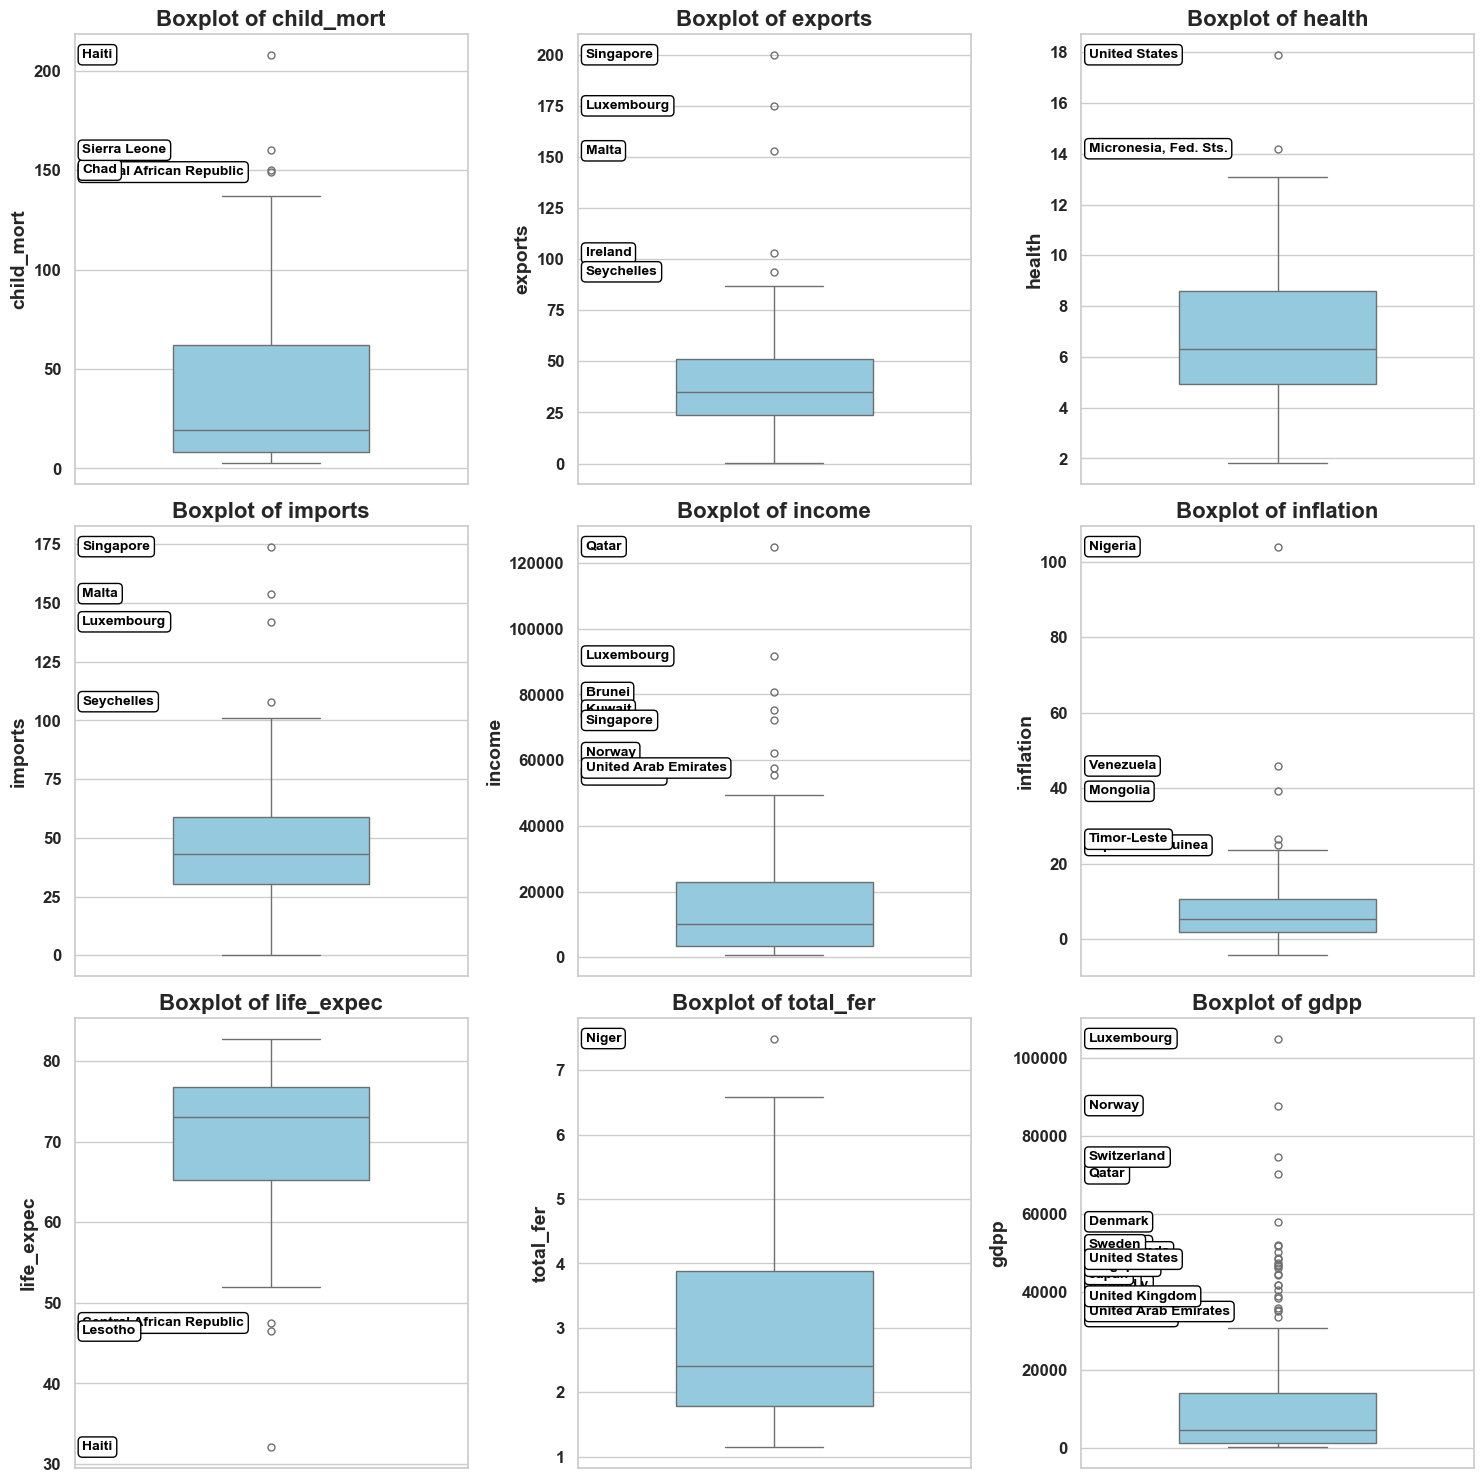

In [8]:
# Boxplot
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"

num_plots = len(num_cols)
ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = sns.boxplot(y=data[col], ax=axes[i], color="skyblue", width=0.5, fliersize=5)
    ax.set_title(f"Boxplot of {col}", fontsize=16, fontweight="bold")
    ax.set_xlabel("")  # No xlabel needed
    ax.set_ylabel(col, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", which="major", labelsize=12, width=2)
    
    # Make axis tick labels bold
    for label in ax.get_xticklabels():
        label.set_fontweight("bold")
    for label in ax.get_yticklabels():
        label.set_fontweight("bold")
    
    # -- Manually compute outliers using the IQR rule --
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter rows where the value is an outlier
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    # Label outliers with the country name with a bounding box tag
    for idx, row in outliers.iterrows():
        y_val = row[col]
        ax.text(
            0.02, y_val,
            s=row["country"],
            ha="left",
            va="center",
            fontweight="bold",
            fontsize=10,
            color="black",
            bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"),
            transform=ax.get_yaxis_transform()  # Align with y-axis scale
        )

# Remove extra subplots if num_cols isn't divisible by ncols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

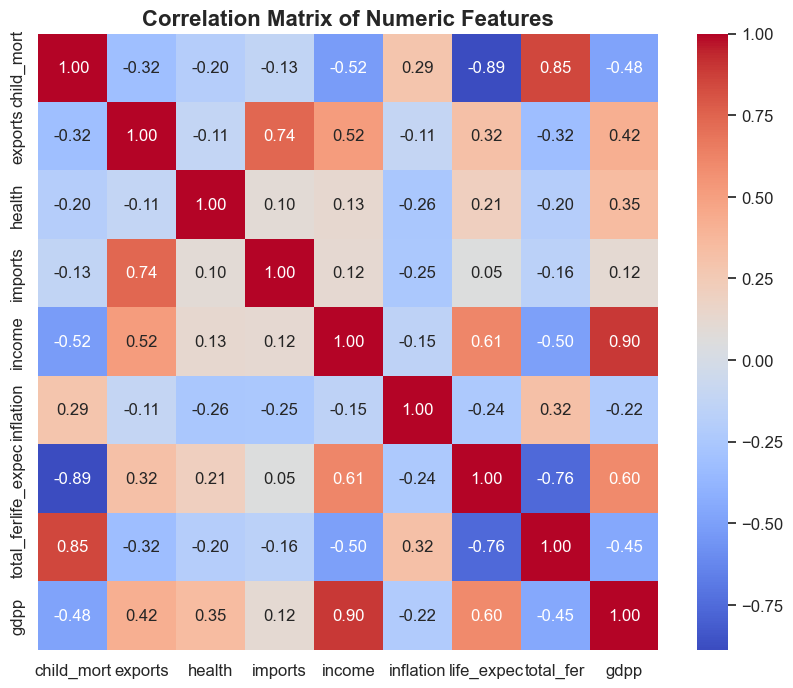

In [9]:
# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
corr_matrix = data[num_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix of Numeric Features")
plt.show()

In [10]:
# Standardize numeric features (important for clustering)
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[num_cols] = scaler.fit_transform(data[num_cols])

print("\nFirst 5 rows of the standardized dataset:")
print(data_scaled.head())


First 5 rows of the standardized dataset:
               country  child_mort   exports    health   imports    income  \
0          Afghanistan    1.291532 -1.138280  0.279088 -0.082455 -0.808245   
1              Albania   -0.538949 -0.479658 -0.097016  0.070837 -0.375369   
2              Algeria   -0.272833 -0.099122 -0.966073 -0.641762 -0.220844   
3               Angola    2.007808  0.775381 -1.448071 -0.165315 -0.585043   
4  Antigua and Barbuda   -0.695634  0.160668 -0.286894  0.497568  0.101732   

   inflation  life_expec  total_fer      gdpp  
0   0.157336   -1.619092   1.902882 -0.679180  
1  -0.312347    0.647866  -0.859973 -0.485623  
2   0.789274    0.670423  -0.038404 -0.465376  
3   1.387054   -1.179234   2.128151 -0.516268  
4  -0.601749    0.704258  -0.541946 -0.041817  


In [11]:
# Modeling

# Prepare data
X = data_scaled.drop(columns=['country']) # 'country' is a separate column we won't use in clustering.

K=2, Silhouette Score=0.2663
K=3, Silhouette Score=0.2856
K=4, Silhouette Score=0.2880
K=5, Silhouette Score=0.3009
K=6, Silhouette Score=0.2357
K=7, Silhouette Score=0.2479
K=8, Silhouette Score=0.2020
K=9, Silhouette Score=0.1923
K=10, Silhouette Score=0.1962


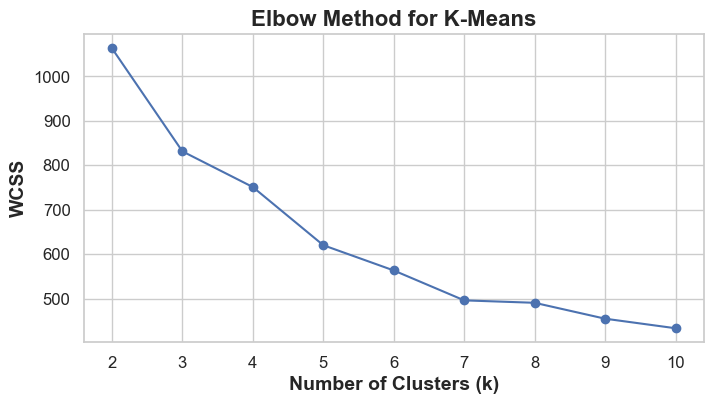

In [12]:
# K-means clustering
k_values = range(2, 11)
silhouette_scores_kmeans = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    labels = kmeans.labels_
    score = silhouette_score(X, labels)
    silhouette_scores_kmeans.append(score)
    print(f"K={k}, Silhouette Score={score:.4f}")

# Elbow method
wcss = [] # within-cluster sum of squares
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(k_values, wcss, marker='o')
plt.title("Elbow Method for K-Means")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("WCSS")
plt.show()

In [13]:
# Hierarchical clustering
linkages = ['ward', 'complete', 'average']
k_values = range(2, 11)

results = [] # Store tuples of (linkage, n_clusters, silhouette_score)

for link in linkages:
    for k in k_values:
        hierarchical = AgglomerativeClustering(n_clusters=k, linkage=link)
        hierarchical.fit(X)
        labels = hierarchical.labels_
        
        score = silhouette_score(X, labels)
        
        results.append((link, k, score))
        print(f"Linkage={link}, n_clusters={k}, Silhouette Score={score:.4f}")

# Identify the best combination of linkage and n_clusters based on silhouette score
best_linkage, best_k, best_score = max(results, key=lambda x: x[2])
print(f"\nBest Hierarchical Clustering combination:")
print(f"Linkage={best_linkage}, n_clusters={best_k}, Silhouette Score={best_score:.4f}")

Linkage=ward, n_clusters=2, Silhouette Score=0.3153
Linkage=ward, n_clusters=3, Silhouette Score=0.2456
Linkage=ward, n_clusters=4, Silhouette Score=0.2481
Linkage=ward, n_clusters=5, Silhouette Score=0.2193
Linkage=ward, n_clusters=6, Silhouette Score=0.2177
Linkage=ward, n_clusters=7, Silhouette Score=0.2419
Linkage=ward, n_clusters=8, Silhouette Score=0.2339
Linkage=ward, n_clusters=9, Silhouette Score=0.2371
Linkage=ward, n_clusters=10, Silhouette Score=0.2076
Linkage=complete, n_clusters=2, Silhouette Score=0.2726
Linkage=complete, n_clusters=3, Silhouette Score=0.2901
Linkage=complete, n_clusters=4, Silhouette Score=0.2864
Linkage=complete, n_clusters=5, Silhouette Score=0.2460
Linkage=complete, n_clusters=6, Silhouette Score=0.2335
Linkage=complete, n_clusters=7, Silhouette Score=0.2276
Linkage=complete, n_clusters=8, Silhouette Score=0.2192
Linkage=complete, n_clusters=9, Silhouette Score=0.2159
Linkage=complete, n_clusters=10, Silhouette Score=0.1700
Linkage=average, n_cluster

In [14]:
# DBSCAN
eps_values = np.arange(0.1, 2.1, 0.1)
min_samples_values = range(3, 21, 2)

best_dbscan_score = -1
best_dbscan_params = (None, None)

dbscan_results = [] # Store results for analysis or plotting

for epsv in eps_values:
    for mins in min_samples_values:
        dbscan = DBSCAN(eps=epsv, min_samples=mins)
        dbscan.fit(X)
        labels = dbscan.labels_

        # Check if we have at least 2 clusters
        unique_labels = set(labels)
        if len(unique_labels) > 1:
            score = silhouette_score(X, labels)
            dbscan_results.append((epsv, mins, score, len(unique_labels)))
            print(f"DBSCAN(eps={epsv}, min_samples={mins}) => Silhouette={score:.4f}, Clusters={len(unique_labels)}")
            # Track best silhouette score
            if score > best_dbscan_score:
                best_dbscan_score = score
                best_dbscan_params = (epsv, mins)
        else:
            # If there's only 1 cluster or everything is noise, store None
            dbscan_results.append((epsv, mins, None, len(unique_labels)))
            print(f"DBSCAN(eps={epsv}, min_samples={mins}) => Only one cluster or all noise.")

# Identify the best combination of parameters based on silhouette score
print(f"\nBest DBSCAN params: eps={best_dbscan_params[0]}, min_samples={best_dbscan_params[1]} with Score={best_dbscan_score:.4f}")

DBSCAN(eps=0.1, min_samples=3) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=5) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=7) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=9) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=11) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=13) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=15) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=17) => Only one cluster or all noise.
DBSCAN(eps=0.1, min_samples=19) => Only one cluster or all noise.
DBSCAN(eps=0.2, min_samples=3) => Only one cluster or all noise.
DBSCAN(eps=0.2, min_samples=5) => Only one cluster or all noise.
DBSCAN(eps=0.2, min_samples=7) => Only one cluster or all noise.
DBSCAN(eps=0.2, min_samples=9) => Only one cluster or all noise.
DBSCAN(eps=0.2, min_samples=11) => Only one cluster or all noise.
DBSCAN(eps=0.2, min_samples=13) => Only one cluster or all noise.
DBSCAN(eps=0.2, mi

In [15]:
# Fit model recommendation
kmeans_3 = KMeans(n_clusters=3, random_state=42)
kmeans_3.fit(X)
kmeans_3_labels = kmeans_3.labels_

# Add cluster labels to the dataframe
data['Cluster'] = kmeans_3_labels
data_scaled['Cluster'] = kmeans_3_labels

In [16]:
# Cluster profiling
# Group by cluster and compute mean of each numeric feature
cluster_means = data.groupby('Cluster').mean(numeric_only=True)
cluster_sizes = data['Cluster'].value_counts().sort_index()
summary_table = cluster_means
summary_table['Cluster_Size'] = cluster_sizes

print("Average values of each feature per cluster (original scale):")
print(summary_table)

Average values of each feature per cluster (original scale):
         child_mort    exports    health    imports        income  inflation  \
Cluster                                                                        
0         22.456977  40.273128  6.251047  47.362394  12321.744186   7.720884   
1          5.000000  58.738889  8.807778  51.491667  45672.222222   2.671250   
2         95.106667  28.602444  6.301111  42.306667   3539.844444  11.986778   

         life_expec  total_fer          gdpp  Cluster_Size  
Cluster                                                     
0         72.566279   2.340349   6461.767442            86  
1         80.127778   1.752778  42494.444444            36  
2         59.055556   5.065333   1766.711111            45  


In [ ]:
# Visualize feature distributions by cluster
features_to_plot = ['child_mort', 'exports', 'health', 'imports',
                    'income', 'inflation', 'life_expec', 'total_fer', 'gdpp']

# Map numeric clusters to descriptive names
data['Cluster'] = data['Cluster'].map({
    0: "Emerging",
    1: "Developed",
    2: "High-need"
})

# Define the custom color palette
custom_palette = {
    "Developed": "green",    # Developed countries in green
    "Emerging": "blue",      # Emerging countries in blue
    "High-need": "red"         # High-need countries in red
}

# Set the overall style and font sizes
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (15, 10)
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.titleweight"] = "bold"

num_plots = len(features_to_plot)
ncols = 3
nrows = math.ceil(num_plots / ncols)

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

for i, feat in enumerate(features_to_plot):
    # Use the custom_palette instead of the default "pastel"
    ax = sns.boxplot(x='Cluster', y=feat, data=data, ax=axes[i], palette=custom_palette)
    ax.set_title(f"Distribution of {feat} by Cluster", fontsize=16, fontweight="bold")
    ax.set_xlabel("Cluster", fontsize=14, fontweight="bold")
    ax.set_ylabel(feat, fontsize=14, fontweight="bold")
    ax.tick_params(axis="both", which="major", labelsize=12, width=2)
    
    # Make axis tick labels bold
    for label in ax.get_xticklabels():
        label.set_fontweight("bold")
    for label in ax.get_yticklabels():
        label.set_fontweight("bold")
    
    # Create a mapping from cluster label to its x-axis coordinate
    xticks = ax.get_xticks()  # numeric positions of each category
    xticklabels = [label.get_text() for label in ax.get_xticklabels()]
    cluster_positions = {str(cat): pos for cat, pos in zip(xticklabels, xticks)}
    
    # For each cluster, compute outliers using the IQR rule and annotate them
    for cluster in data['Cluster'].unique():
        cluster_data = data[data['Cluster'] == cluster]
        Q1 = cluster_data[feat].quantile(0.25)
        Q3 = cluster_data[feat].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        # Get the outlier rows for this cluster
        outliers = cluster_data[(cluster_data[feat] < lower_bound) | (cluster_data[feat] > upper_bound)]
        
        # Determine the x-coordinate for this cluster box
        cluster_str = str(cluster)
        x_pos = cluster_positions.get(cluster_str, None)
        if x_pos is None:
            continue
        
        # Annotate each outlier with its country label.
        # The x offset (-0.2) shifts the text slightly to the left of the box center.
        for idx, row in outliers.iterrows():
            y_val = row[feat]
            ax.text(x_pos - 0.2, y_val, row["country"],
                    ha="right", va="center", fontweight="bold", fontsize=10,
                    color="black",
                    bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.3"))
            
# Remove extra subplots if the number of plots isn't divisible by ncols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
    
plt.tight_layout()
plt.show()

/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_1984/3471101462.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=feat, data=data, ax=axes[i], palette=custom_palette)
/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_1984/3471101462.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster', y=feat, data=data, ax=axes[i], palette=custom_palette)
/var/folders/ly/w484tkcx5c7c7ybl9rgjy09r000fsz/T/ipykernel_1984/3471101462.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Cluster',

In [ ]:
# Visualize world map

# Create the choropleth map with custom colors
fig = px.choropleth(
    data_frame=data,
    locations="country",
    locationmode="country names",
    color="Cluster",
    hover_name="country",
    color_discrete_map={
        "Developed": "green",
        "Emerging": "blue",  
        "High-need": "red"   
    },
    title="Clusters of Countries by K-Means (3 Clusters)",
    projection="natural earth"
)

fig.update_layout(legend_title_text='Country Type')
fig.show()
fig.write_image("world_map.png")